In [2]:
import os
import sys
sys.path.append("..")
import pickle

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

mpl.rcParams["figure.dpi"] = 300
sns.set(font_scale=0.8)

from src.utils import create_total_df

In [3]:
def data_binning(df: pd.DataFrame, target_labels: list):
    thresh = np.arange(0, 0.8, 0.1)
    thresh = np.append(thresh, 1.0)
    bin_dic = {}
    tick_names = []
    violin_data_dic = {label: [] for label in target_labels}
    for i in range(len(thresh) - 1):
        upper_th = thresh[i + 1]
        lower_th = thresh[i]
        tmp_df = df[(df["cos_sim"] > lower_th) & (df["cos_sim"] < upper_th)]
        for label in target_labels:
            violin_data_dic[label].append(tmp_df[label].values)
        tmp_dic = tmp_df.describe().loc["mean", target_labels]
        tmp_dic["count"] = tmp_df.describe().loc["count"].values[0]
        bin_dic[f"{lower_th:.1f}-{upper_th:.1f}"] = tmp_dic
        tick_names.append(f"{lower_th:.1f}-{upper_th:.1f}")
    tick_names.append("All")
    bin_dic["All"] = dict(df.describe().loc["mean", target_labels], count=len(df))
    bin_df = pd.DataFrame(bin_dic).T
    return (violin_data_dic, tick_names, bin_df)

In [ ]:
seq_df = pd.read_csv("../data/human/gencode44_utr_gene_unique_cdhit09.csv")

rinalmo1 = "../results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"
rinalmo2 = "../results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed2"

total_df1 = create_total_df(rinalmo1, seq_df)
total_df2 = create_total_df(rinalmo2, seq_df)

concat = pd.merge(
    total_df1.iloc[:, 4:9], total_df2.iloc[:, 4:9], on="ENST_ID", how="inner"
)

## Relation Score Bin distribution

In [7]:
targets = ["5UTR_len", "3UTR_len", "CDS_len", "total_len"]
violin_data_dic, tick_names, bin_df = data_binning(total_df1, target_labels=targets)

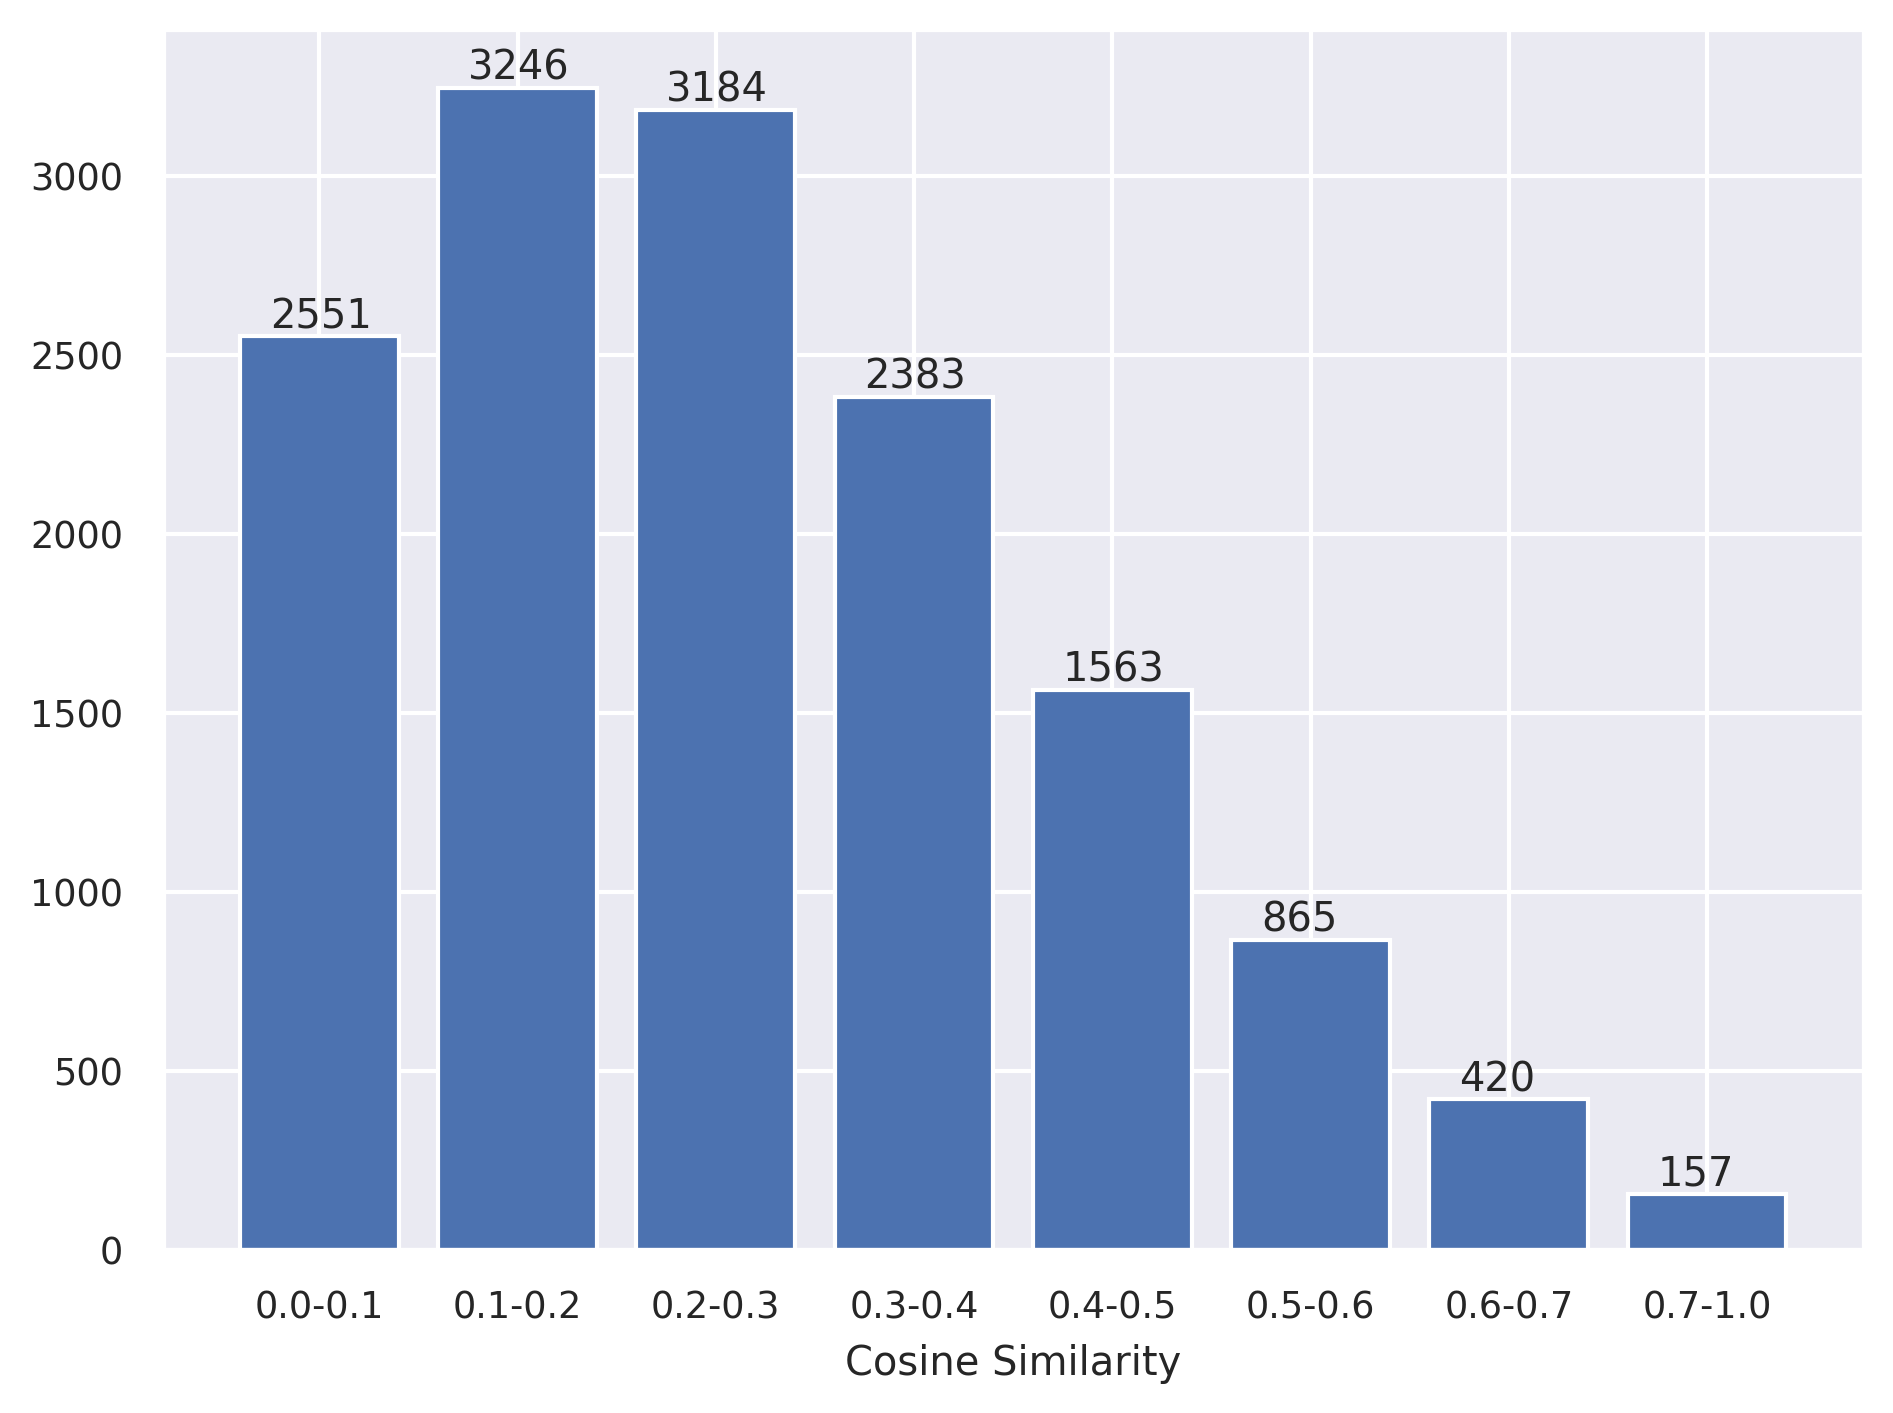

In [8]:
plt.bar(x=tick_names[:-1], height=bin_df["count"][:-1])
plt.xlabel("Cosine Similarity")
for i, count in enumerate(bin_df["count"][:-1]):
    plt.text(i - 0.25, count + 25, f"{int(count)}")
plt.tight_layout()
# plt.savefig('./results/imgs/cosine_similarity_sample_dist_rinalmo.png')

## Check difference between experiments

In [ ]:
seq_df = pd.read_csv("../data/human/gencode44_utr_gene_unique_cdhit09.csv")

rinalmo1 = "../results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed1"
rinalmo2 = "../results/runs/contrastive_learning_10fold_rinalmo_whole_ave_seed2"

In [8]:
total_df1 = create_total_df(rinalmo1,seq_df)
total_df2 = create_total_df(rinalmo2,seq_df)

concat = pd.merge(
    total_df1.iloc[:, 4:9], total_df2.iloc[:, 4:9], on="ENST_ID", how="inner"
)

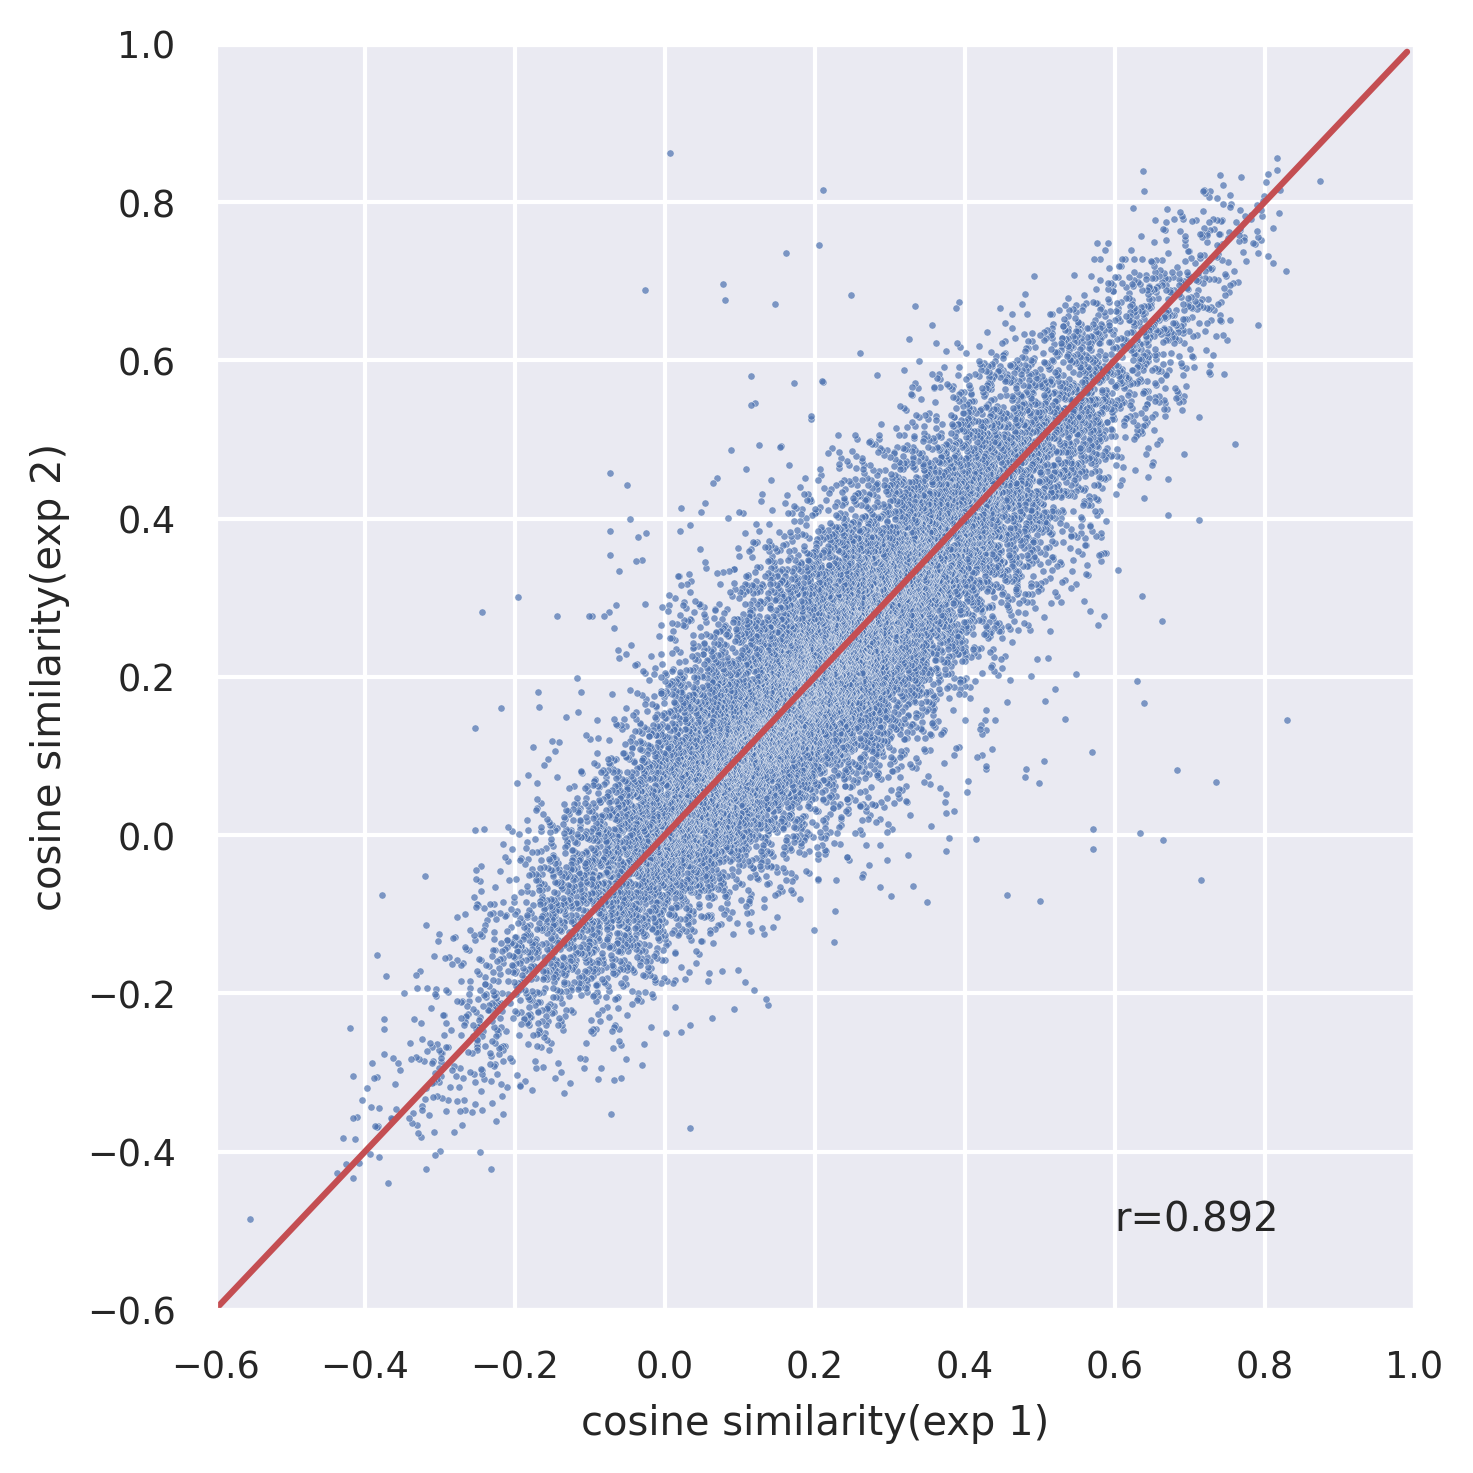

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
x = concat["cos_sim_x"]
y = concat["cos_sim_y"]
label_name = "cosine similarity"
line = np.arange(-0.6, 1, 0.01)
pear, _ = pearsonr(x, y)
r2 = r2_score(x, y)

sns.scatterplot(x=x, y=y, alpha=0.7, s=3, ax=ax)
sns.lineplot(x=line, y=line, color="r", ax=ax)
ax.text(0.6, -0.5, f"r={pear:.3f}")
ax.set_xlim(-0.6, 1)
ax.set_ylim(-0.6, 1)
ax.set_xlabel(f"{label_name}(exp 1)")
ax.set_ylabel(f"{label_name}(exp 2)")
plt.tight_layout()
#plt.savefig("../results/imgs/exp_diff_CL_rinalmo_seaborn_paper")

## Gene enrichment analysis

In [ ]:
go_child_df = pd.read_csv(
    "../results/analysis/metascape_rinalmo_cossim_0.7-1.0_genes/Enrichment_GO/GO_membership.csv"
)

go_child_df_selected = (
    go_child_df[go_child_df["GO"].str.contains("GO:")]
    .sort_values("_LogP_GENE", ascending=False)
    .iloc[-5:]
)
# For visualization.
go_child_df_selected["Description"].values[
    1
] = "plasma membrane bounded \n cell projection morphogenesis"

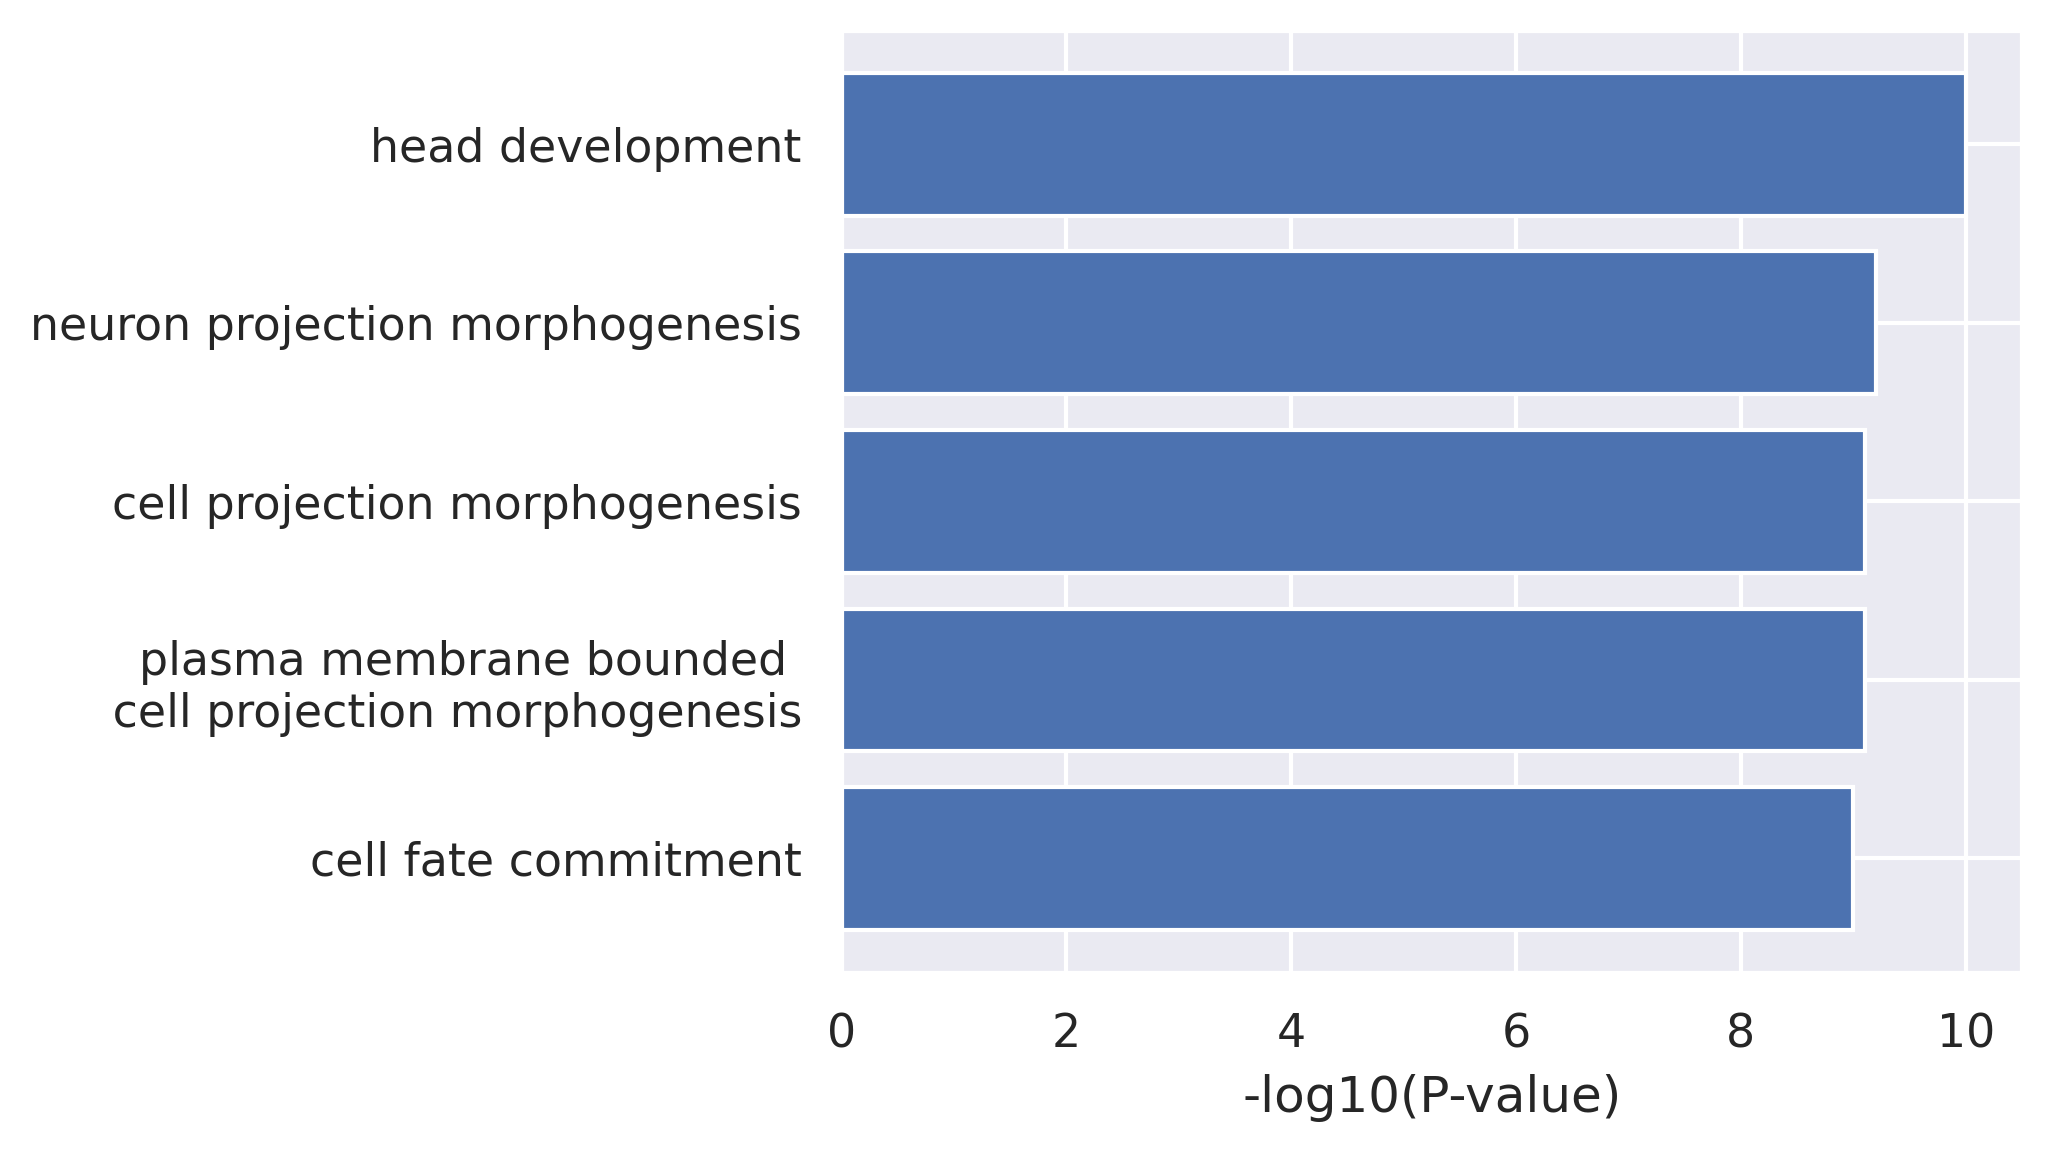

In [ ]:
labels = go_child_df_selected["Description"]

plt.figure(figsize=(7, 4))
plt.barh(
    y=np.arange(len(go_child_df_selected)),
    width=-go_child_df_selected["_LogP_GENE"],
    tick_label=labels,
)
plt.xlabel("-log10(P-value)")
plt.tight_layout()
# plt.savefig('./results/imgs/barh_metascape_top5_rinalmo_cossim_0.7-1.0.png')